# 프로젝트 : 주식 예측에 도전

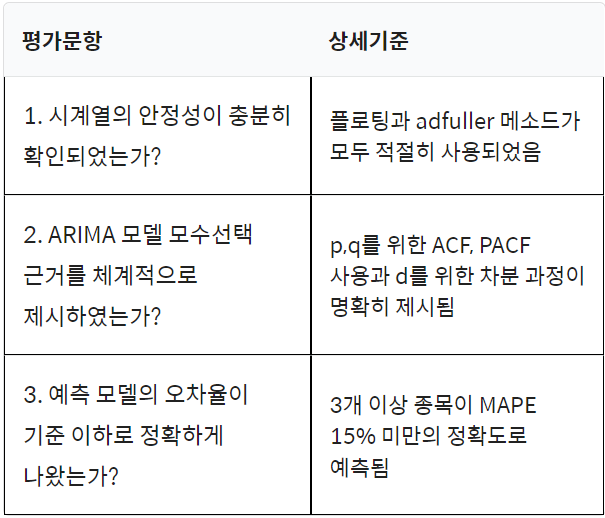

### 삼성전자 주식데이터를 활용하는데 단, 종가(Close)만 활용하여 분석 수행한다.


# 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

print('모듈 준비 완료')

모듈 준비 완료


In [2]:
#dataset_filepath = os.getenv('/aiffel/stock_prediction/data/samsung.csv')
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/samsung.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [3]:
ts

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64

 # 2. 각종 전처리 수행

## 2-1) 결측치 처리

In [4]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### ▶결측치가 없음을 확인

## 2-2) 로그 변환

In [5]:
ts_log = np.log(ts)

# 3. 시계열 안정성 분석

## 3-1) 정성적 그래프 분석

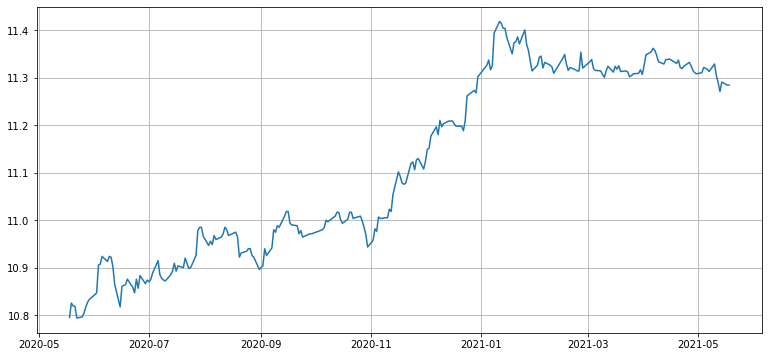

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts_log)
plt.grid()

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


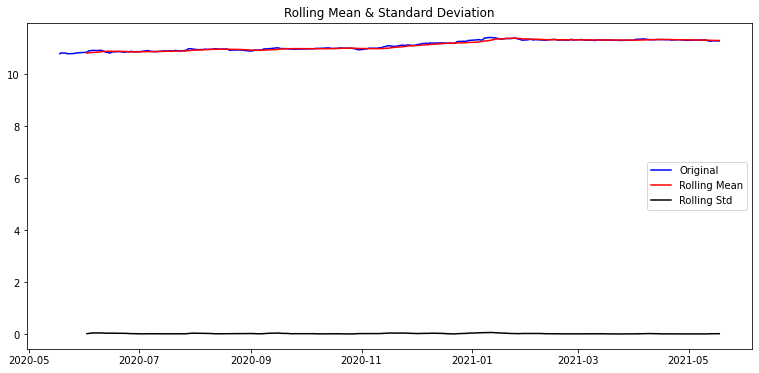

In [8]:
plot_rolling_statistics(ts_log, window=12)

#### ▶ 그래프를 겉보기로는 stationary라고 할 수 있지만 보다 명확하게 판다 하기 위해서는 수치적인 검증이 필요하다.

## 3-2) 정량적 Augmented Dicky-Fuller Test

### ADF Test란?   

시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법.

주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택

ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로 검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적인 시계열 데이터

유의 확률(significance probability, asymptotic significance)
p-값(p-value, probability value)    
---> 귀무가설이 맞다고 가정할 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률

### statsmodels 패키지와 adfuller 활용하여 ADF test를 수행

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('완료')

완료


In [10]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


#### ▶ p-value가 0.59로 상당히 크므로 여기서 설정한 귀무가설(nonstationary)을 기각하기 어렵다.

### 3-3) 시계열 분해 (Time Series Decomposition)

##### 시계열 데이터를 Trend/Cycle/Seasonal/Residual 요소룰 분해하는 기법

1. Trend(추세) : 데이터가 장긱적으로 증가하거나 감소하는 것이며, 추세가 꼭 선형적일 필요는 없다.   

2. Cycle(순환) : 경기변동과 같이 정치,경제,사회적 요인에 의한 변화로 일정 주기가 없으며 장기적인 변화현상   

3. Seasonal(계절성) : 주,월,분기,반기 단위 등 특정 시간의 주기로 나타나는pattern   

4. Residual(불규칙요소) : 설명될 수 없는 요인 또는 돌발적인 요인에 의하여 일어나는 변화로. 예측 불가능한 임이의 변동. trend,cycle,seasonal을 제외한 모는 요소.

5. Trend+Seasonality+Residual = Original

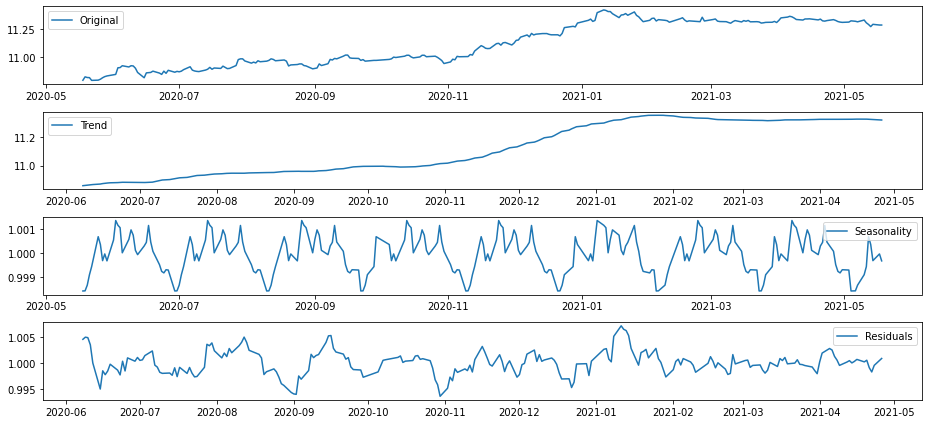

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### ▶ Trend는 "2020-12" 전후에서 큰 변화를 보이는 것 이외에 constant한것으로 개인적으로 판단됨.
#### ▶ seasonal로는 1~1.5개월 주기로 반복되는 pattern이 보임.
#### ▶ residual의 graph로는 판단하기 하기 어려워서 다음의 report로 확인할 수 있었음.

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


#### ▶ 위 report를 통해서 거의 0에 가까운 p-value를 확인할 수 있으므로 INPUT데이터의 stationary 하다고 판단 할 수 있었음.

# 4. 학습, 테스트 데이터셋 생성

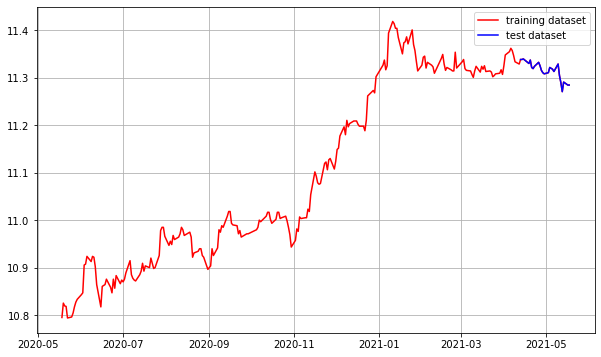

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [14]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


#### ▶ 제일 최근의 데이터 10%를 test로 설정

# 5. 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기

## 5-1. "ARIMA(Autoregressive Integrated Moving Average)" model

### ① AR(자기회귀, Autoregressive)

변수의 과거 값의 선형 조합을 이용하여 관심 있는 변수를 예측   
단어에서 알수 있듯이 자기 자신에 대한 변수의 회귀라는 의미.

### ② MA(이동평균, Moving Average)

▶ 회귀에서 목표 예상 변수(forecast variable)의 과거 값을 이용하는 대신에, 이동 평균 모델은 회귀처럼 보이는 모델에서 과거 예측 오차(forecast error)을 이용    

▶ 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있음

▶ 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있음

### ③ I(차분 누적, Integration)

▶ 시계열의 Seasonality에 해당하는 부분을 모델링한다고 볼 수 있음.

## 5-2. "ARIMA(Autoregressive Integrated Moving Average)" model 모수 - p,q,d

p : 자기회귀 모형(AR)의 시차   
d : 차분 누적(I) 횟수   
q : 이동평균 모형(MA)의 시차  

p + q < 2, p * q = 0

### p,q,d 선정 기법

##### ACF(Autocorrelation Function)   
시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수

##### PACF(Partial Autocorrelation Function)
다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

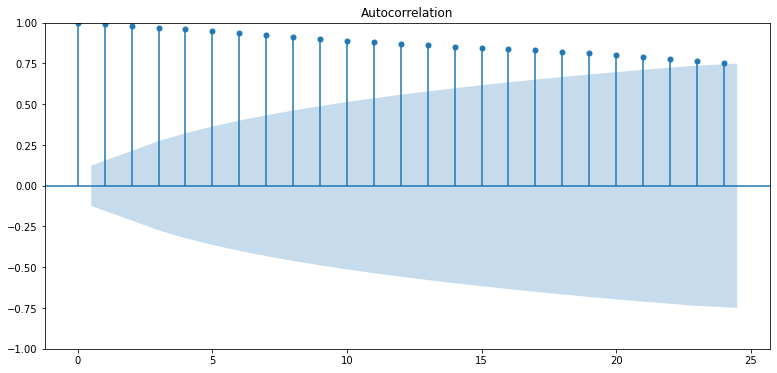

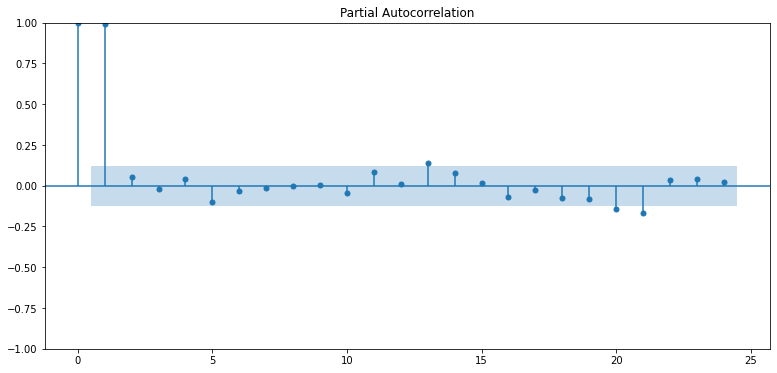

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

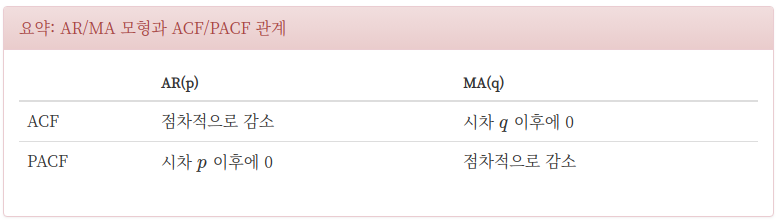

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


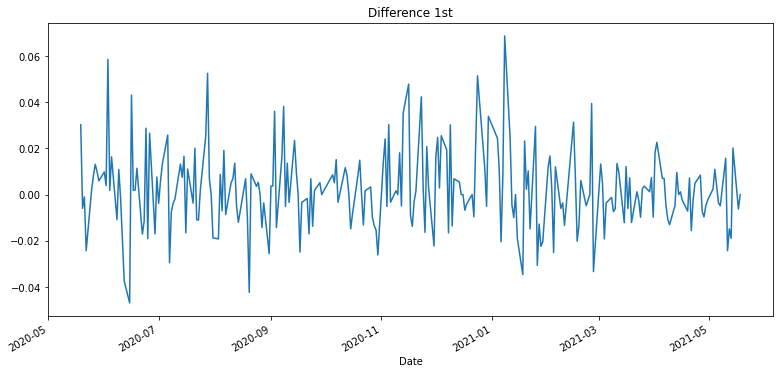

In [16]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


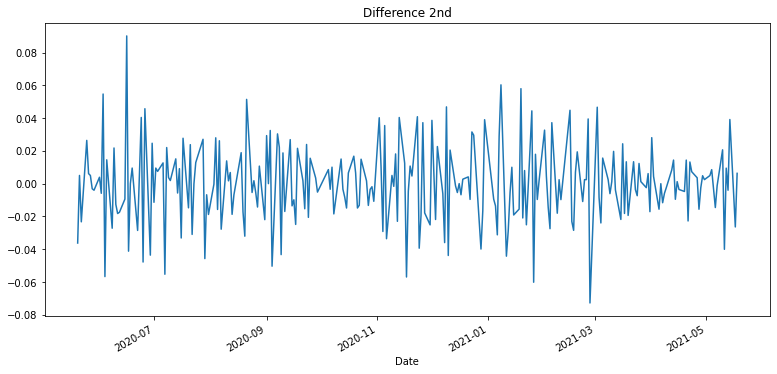

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련   
모델 테스트 및 플로팅   
최종 예측 모델 정확도 측정(MAPE)

In [18]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(14, 1, 0)   Log Likelihood                 587.276
Date:                Thu, 17 Feb 2022   AIC                          -1144.551
Time:                        07:41:46   BIC                          -1093.377
Sample:                             0   HQIC                         -1123.895
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0438      0.067      0.652      0.515      -0.088       0.176
ar.L2         -0.0148      0.080     -0.185      0.853      -0.171       0.142
ar.L3         -0.0397      0.075     -0.528      0.5

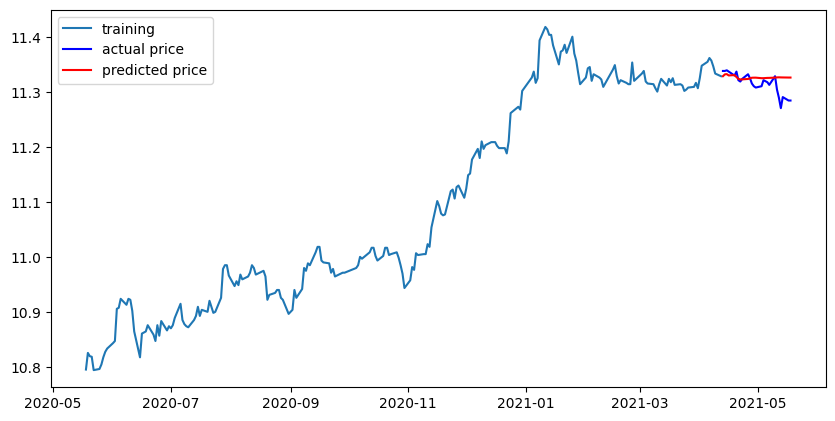

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3003894.0665715677
MAE:  1233.5105152308563
RMSE:  1733.1745632138638
MAPE: 1.53%


### ★MAPE 기준 1.53%로 목표 달성!!!

# 7. 다른 주식 종목 예측해 보기   

관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## 7-1. 시계열 데이터 준비

▶ 미국 차기 코로나백신 제조사인 Novavax의 주가 데이터 활용 (1995~현재)  

In [21]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVAX_monthly.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

nova= df['Close']

In [22]:
nova

Date
1996-01-01     95.000000
1996-02-01    117.500000
1996-03-01    122.500000
1996-04-01    117.500000
1996-05-01    157.500000
                 ...    
2021-11-01    208.630005
2021-12-01    143.070007
2022-01-01     93.699997
2022-02-01     91.790001
2022-02-10     88.000000
Name: Close, Length: 315, dtype: float64

In [23]:
nova = nova.interpolate(method='time')
nova[nova.isna()]

Series([], Name: Close, dtype: float64)

In [24]:
nova_log = np.log(nova)

## 안정적인 시계열(Stationary Time-Series) 자료인지 확인하기

평균, 분산, 공분산(정확히는 자기공분산-autocovariance이라고 해야 함)이 일정한지 확인해바야 함

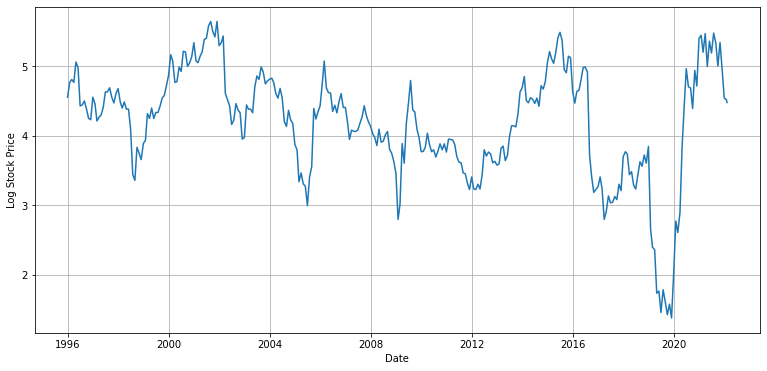

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    

plt.plot(nova_log)
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.grid()

In [26]:
mean_nova_log=np.mean(nova_log)
var_nova_log=np.var(nova_log)
print("log 평균=", round(mean_nova_log,2),"\nlog 분산=", round(var_nova_log,2))

log 평균= 4.18 
log 분산= 0.63


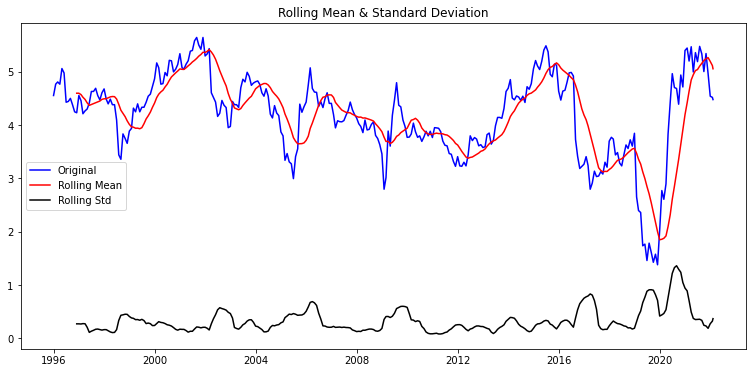

In [27]:
plot_rolling_statistics(nova_log, window=12)

In [28]:
augmented_dickey_fuller_test(nova_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.860807
p-value                          0.050099
#Lags Used                       0.000000
Number of Observations Used    314.000000
Critical Value (1%)             -3.451349
Critical Value (5%)             -2.870789
Critical Value (10%)            -2.571698
dtype: float64


#### ▶ p-value가 0.05로 상당히 작으므로 여기서 설정한 귀무가설(nonstationary)을 기각할 경향이 보인다.

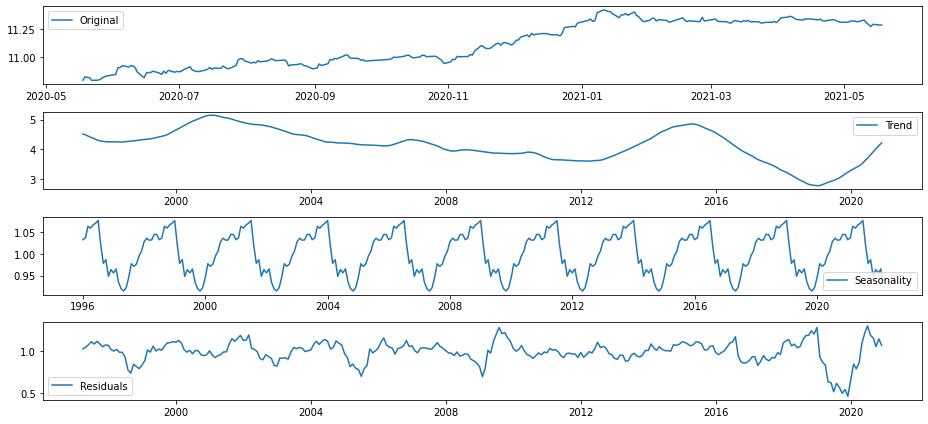

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(nova_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### ▶ Trend는 "2020년" 전에 감소를 보이는 것 이외에 constant한것으로 개인적으로 판단됨. 
#### ▶"2020년"전에는 Covid-19에 의한 주식시장 충격으로 생각됨.
#### ▶ seasonal로는 2년주기로 반복되는 pattern이 보임.
#### ▶ residual의 graph로는 판단하기 하기 어려워서 다음의 report로 확인할 수 있었음.

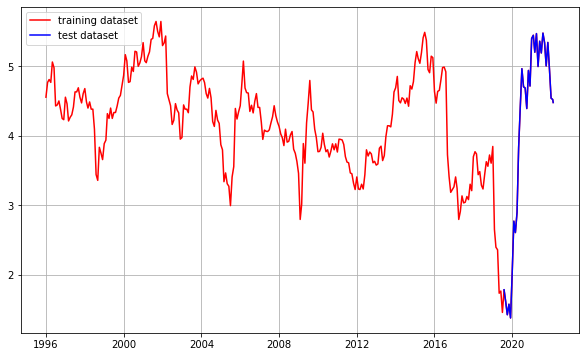

In [30]:
train_data, test_data = nova_log[:int(len(nova_log)*0.9)], nova_log[int(len(nova_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(nova_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### ▶ test_data는 2020년 이후의 데이터들로 선정하였는데 이당시 covid-19에 의한 pendemic이 있다는걸 염두해야 된다고 사료됨.

In [31]:
print(nova_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
1996-01-01    4.553877
1996-02-01    4.766438
Name: Close, dtype: float64
(283,)
(32,)


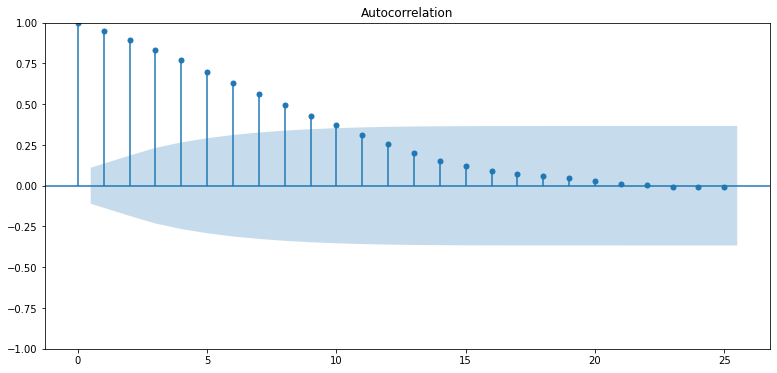

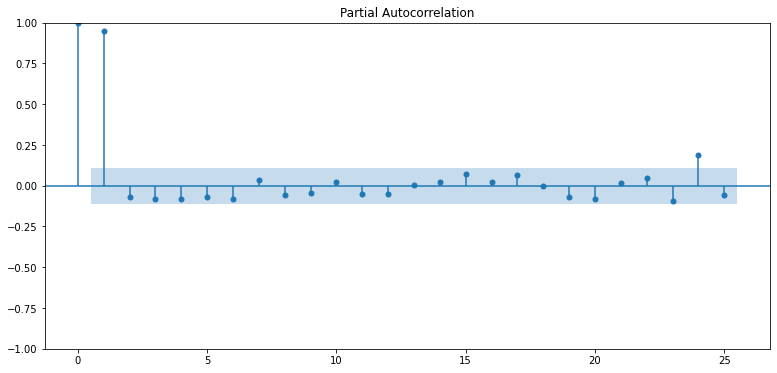

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(nova_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(nova_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.704617e+01
p-value                        8.130836e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.130000e+02
Critical Value (1%)           -3.451416e+00
Critical Value (5%)           -2.870819e+00
Critical Value (10%)          -2.571714e+00
dtype: float64


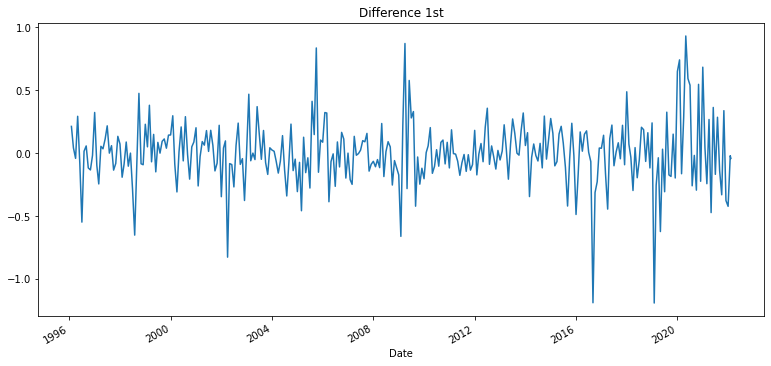

In [33]:
# 1차 차분 구하기
diff_1 = nova_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.965541e+00
p-value                        8.008012e-15
#Lags Used                     9.000000e+00
Number of Observations Used    3.030000e+02
Critical Value (1%)           -3.452118e+00
Critical Value (5%)           -2.871127e+00
Critical Value (10%)          -2.571878e+00
dtype: float64


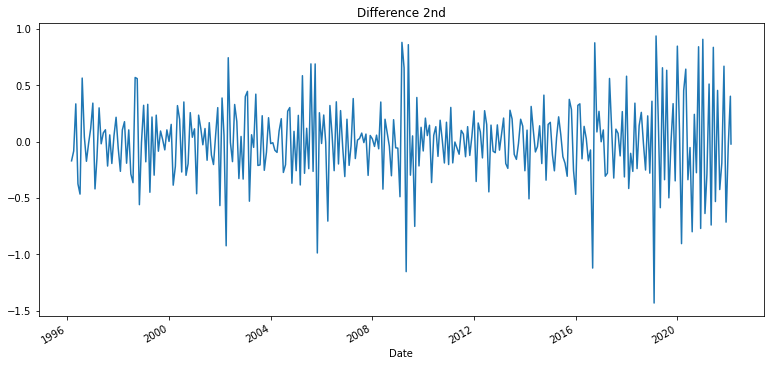

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [35]:
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  283
Model:                ARIMA(14, 1, 0)   Log Likelihood                  15.822
Date:                Thu, 17 Feb 2022   AIC                             -1.643
Time:                        07:41:49   BIC                             52.985
Sample:                    01-01-1996   HQIC                            20.263
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0396      0.067      0.587      0.557      -0.093       0.172
ar.L2         -0.0073      0.053     -0.138      0.891      -0.111       0.096
ar.L3          0.0263      0.057      0.459      0.6

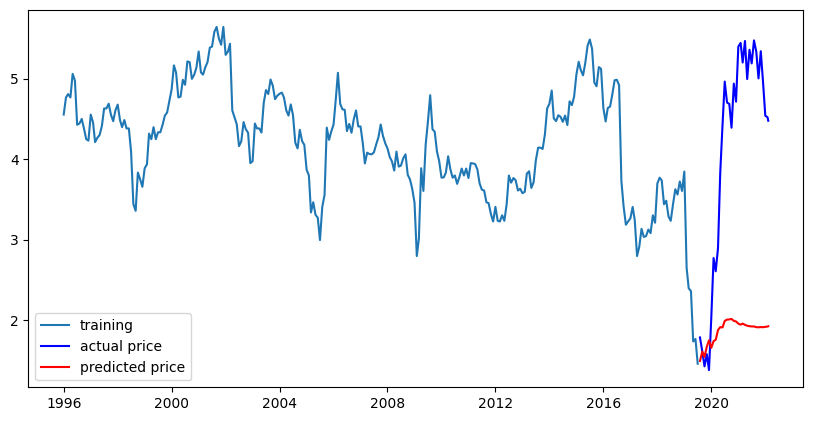

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17073.307458346673
MAE:  103.98713384454695
RMSE:  130.66486696257212
MAPE: 77.51%


----

# 회고

그제 안전한 Novavax백신을 접종하여 이회사의 주식을 선정해보았다. pendemic만 없었으면 예측오류가 이보다 크지 않을 것으로 판단하는데 이것이 바로 residual요소에 의해 stationary가 많이 훼손된 것으로 생각된다. 기계공학 전공 공부하면서 어렵고 복잡한 수학을 많이 접하게 되면서 내 전공이 수학아닌가 하는 의심이 들었었지만 이번 exploration을 하면서 통계공부를 하는듯한 느낌이 든다. 특히 ACF, PACF는 아무리 알아바도 의미를 이해하기 힘들었다. 주식에는 관심없어서 잘은 모르지만 나름 유익한 것 같았으면 다른 응용사례에 대해서 좀더 알아보고 싶다.